Run with: sudo docker run --gpus all -it --rm -v $(pwd):/tf/notebooks -p 8888:8888 tensorflow/tensorflow:2.12.0-gpu-jupyter

In [1]:
!pip install tqdm
!pip install mlxtend
!pip install pandas
!pip install scikit-learn
!pip install akida==2.7.2
!pip install cnn2snn==2.7.2
!pip install imblearn
%pip install akida-models==1.5.0
!pip install seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 15.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 81.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 88.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.0/508.0 kB 47.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is availa

In [2]:
# GB: Adding compatibility check
import cnn2snn
import akida as ak
import os

# Change Akida version
os.environ["CNN2SNN_TARGET_AKIDA_VERSION"] = "v1"

# Double-check Avida version
print(' Akida version: ', cnn2snn.get_akida_version())

# # And HW compatibility?
# myDevice = ak.devices()[0]
# print("Device: ", myDevice.desc)
# x = cnn2snn.check_model_compatibility(model=model_keras, device=myDevice)
# print("Non compatibilities: ", x)

2024-10-10 01:48:51.060923: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 01:48:51.238870: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-10 01:48:52.820502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-10 01:48:52.83

 Akida version:  AkidaVersion.v1


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from glob import glob
from PIL import Image
import shutil
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import warnings

from IPython.display import clear_output

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from mlxtend.plotting import plot_confusion_matrix

seed = (4,2)

In [4]:
os.chdir('notebooks/Documents/GitHub/GENG5551-Akida-Chip')
os.getcwd()

'/tf/notebooks/Documents/GitHub/GENG5551-Akida-Chip'

In [5]:
df = pd.read_csv('archive/HAM10000_metadata.csv')

size = (64, 64)

In [6]:
base_dir = './archive'
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

In [7]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize(size)))

In [8]:
df = df[['dx', 'image']]

In [9]:
df.head()

,dx,image
0,bkl,"[[[191, 152, 194], [191, 153, 195], [192, 149,..."
1,bkl,"[[[23, 13, 23], [25, 14, 28], [37, 24, 46], [6..."
2,bkl,"[[[186, 129, 140], [192, 136, 151], [198, 143,..."
3,bkl,"[[[24, 11, 19], [36, 20, 30], [64, 38, 50], [9..."
4,bkl,"[[[139, 95, 118], [158, 114, 138], [178, 133, ..."


In [10]:
df['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

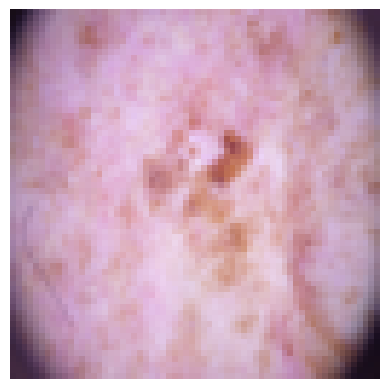

In [11]:
arr = df.iloc[1]['image']
#Image.fromarray(arr)
plt.imshow(arr)
plt.axis('off')
plt.show()

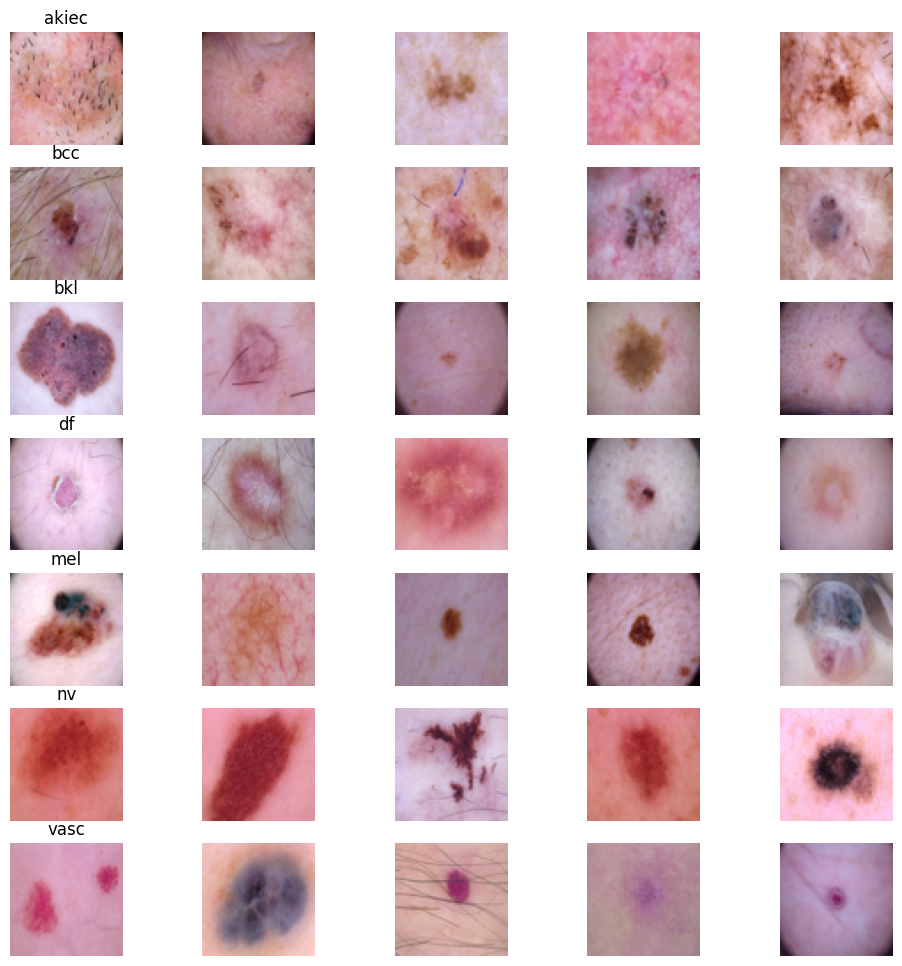

In [12]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (12,12))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=42).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
# fig.savefig('category_samples.png', dpi=300)

In [13]:
counts = pd.DataFrame(df['dx'].value_counts()).reset_index()
counts

,dx,count
0,nv,6705
1,mel,1113
2,bkl,1099
3,bcc,514
4,akiec,327
5,vasc,142
6,df,115


In [14]:
df_nv = df[df['dx'] == 'nv']

In [15]:
df_df = df[df['dx'] == 'df']

In [16]:
vasc_df = df[df['dx'] == 'vasc']

In [17]:
akiec_df = df[df['dx'] == 'akiec']

In [18]:
bcc_df = df[df['dx'] == 'bcc']

In [19]:
bkl_df = df[df['dx'] == 'bkl']

In [20]:
mel_df = df[df['dx'] == 'mel']

# Data Augmentation

In [21]:
def aug_brightness(img_arr):
    aug_arr = tf.image.stateless_random_brightness(img_arr, 0.7, seed)
    aur_arr = np.array(aug_arr)

    return aug_arr

In [22]:
def aug_contrast(img_arr):
    aug_arr = tf.image.stateless_random_contrast(img_arr, 0.2, 0.8, seed)
    aur_arr = np.array(aug_arr)

    return aug_arr

In [23]:
def aug_flip_left_right(img_arr):
    aug_arr = tf.image.stateless_random_flip_left_right(img_arr, seed).numpy().tolist()
    aur_arr = np.array(aug_arr)

    return aug_arr

In [24]:
def aug_flip_up_down(img_arr):
    aug_arr = tf.image.stateless_random_flip_up_down(img_arr, seed).numpy().tolist()
    aur_arr = np.array(aug_arr)

    return aug_arr

In [25]:
def aug_hue(img_arr):
    aug_arr = tf.image.stateless_random_hue(img_arr, 0.5, seed)
    aur_arr = np.array(aug_arr)

    return aug_arr

In [26]:
def aug_saturation(img_arr):
    aug_arr = tf.image.stateless_random_saturation(img_arr, 0.1, 1, seed)
    aur_arr = np.array(aug_arr)

    return aug_arr

In [27]:
func_list = [aug_brightness, aug_contrast, aug_flip_left_right, aug_flip_up_down, aug_hue, aug_saturation]

In [28]:
def random_augmentation(images, dx, num_of_samples):
    new_images = []
    all_indices = []
    while (len(new_images) < num_of_samples):
        indices = np.random.randint(images.shape[0], size=6)
        r = list(map(lambda x, y: x(y), func_list, images.iloc[indices]))
        r = [np.array(tensor) for tensor in r]
        new_images.extend(r)
        all_indices.extend(indices)
        clear_output(wait=True)
        print(str(len(new_images)) + '/' + str(num_of_samples))

    new_images = pd.DataFrame({'dx': dx, 'image': new_images})

    return all_indices, new_images

In [29]:
df_images = df_df['image']
df_indices, df_new_images = random_augmentation(df_images, 'df', 700)

702/700


In [30]:
vasc_images = vasc_df['image']
vasc_indices, vasc_new_images = random_augmentation(vasc_images, 'vasc', 700)

702/700


In [31]:
akiec_images = akiec_df['image']
akiec_indices, akiec_new_images = random_augmentation(akiec_images, 'akiec', 1000)

1002/1000


In [32]:
bcc_images = bcc_df['image']
bcc_indices, bcc_new_images = random_augmentation(bcc_images, 'bcc', 1200)

1200/1200


In [33]:
bkl_images = bkl_df['image']
bkl_indices, bkl_new_images = random_augmentation(bkl_images, 'bkl', 1400)

1404/1400


In [34]:
mel_images = mel_df['image']
mel_indices, mel_new_images = random_augmentation(mel_images, 'mel', 1400)

1404/1400


In [35]:
new_images_df = pd.concat([df_new_images, vasc_new_images, akiec_new_images, bcc_new_images, bkl_new_images, mel_new_images], axis=0).reset_index(drop=True)
aug_df = pd.concat([df, new_images_df], axis=0).reset_index(drop=True)
aug_df = aug_df.sample(frac=1).reset_index(drop=True)

In [36]:
pd.DataFrame(aug_df['dx'].value_counts()).reset_index()

,dx,count
0,nv,6705
1,mel,2517
2,bkl,2503
3,bcc,1714
4,akiec,1329
5,vasc,844
6,df,817


In [37]:
aug_df.shape

(16429, 2)

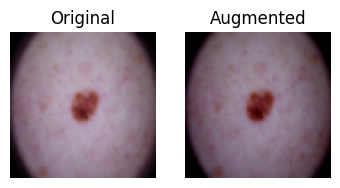

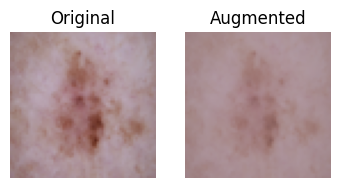

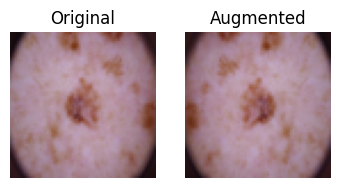

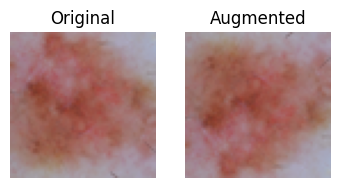

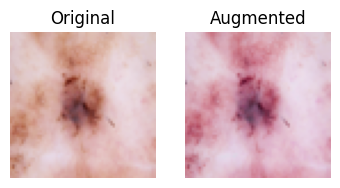

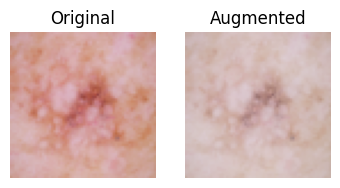

In [38]:
for i in range(12, 18):
    plt.subplot(1, 3, 1)
    plt.imshow(mel_df['image'].iloc[mel_indices[i]])
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mel_new_images['image'].iloc[i])
    plt.title('Augmented')
    plt.axis('off')

    plt.show()

In [39]:
labelEncoder = LabelEncoder()
aug_df['label'] = labelEncoder.fit_transform(aug_df['dx'])

In [40]:
x = np.asarray(aug_df['image'].to_list())
y = to_categorical(aug_df['label'], num_classes=7)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=42, shuffle=True)

In [41]:
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Count the occurrences of each class in training and testing sets
train_counts = pd.Series(y_train_labels).value_counts().sort_index()
test_counts = pd.Series(y_test_labels).value_counts().sort_index()

# Display the counts
print("Training Set Class Distribution:")
print(train_counts)

print("\nTesting Set Class Distribution:")
print(test_counts)

Training Set Class Distribution:
0    1071
1    1344
2    2017
3     663
4    2016
5    5351
6     681
Name: count, dtype: int64

Testing Set Class Distribution:
0     258
1     370
2     486
3     154
4     501
5    1354
6     163
Name: count, dtype: int64


**SMOTE TECHNIQUE**

In [42]:
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [43]:
# Assuming x_train, y_train, x_test, y_test are already defined
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)


In [44]:
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)


In [45]:
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train_reshaped, y_train.argmax(axis=1))


In [46]:
x_train_smote = x_train_smote.reshape(x_train_smote.shape[0], 64, 64, 3)
y_train_smote = tf.keras.utils.to_categorical(y_train_smote, num_classes=7)


Training Set Class Distribution After SMOTE:
0    5351
1    5351
2    5351
3    5351
4    5351
5    5351
6    5351
Name: count, dtype: int64


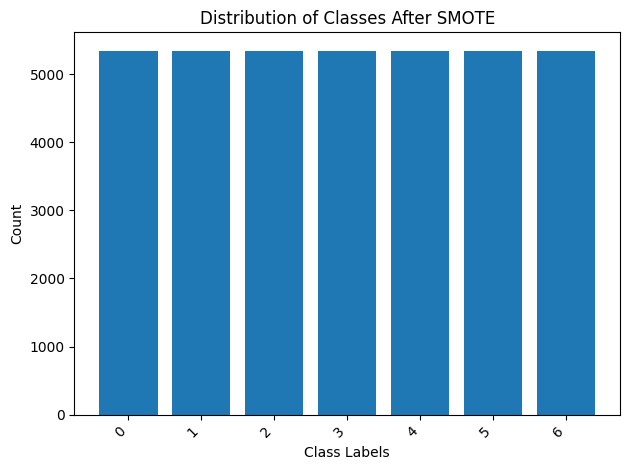

In [47]:
# prompt: i want bar plot of distribution of clases after the SMOTE

import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# ... (Your existing code)

# Count the occurrences of each class after SMOTE
train_counts_smote = pd.Series(y_train_smote.argmax(axis=1)).value_counts().sort_index()

# Display the counts
print("Training Set Class Distribution After SMOTE:")
print(train_counts_smote)

# Bar plot of class distribution after SMOTE
plt.bar(train_counts_smote.index, train_counts_smote.values)
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Distribution of Classes After SMOTE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


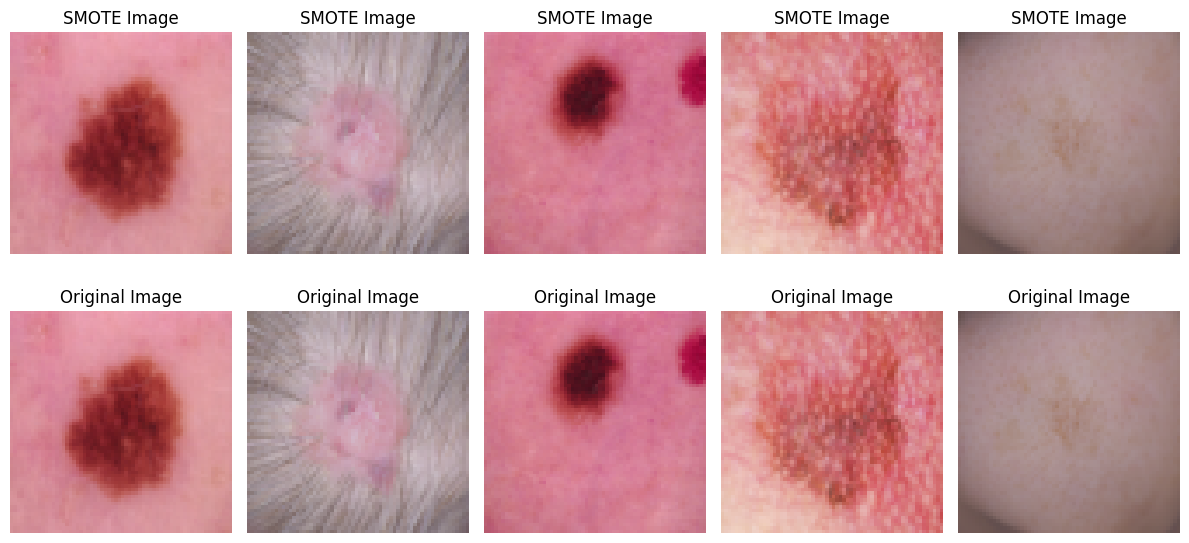

In [48]:
# prompt: print the smote images and the normal images of datset

import matplotlib.pyplot as plt
# Display some SMOTE images and original images for comparison
n_samples = 5
fig, m_axs = plt.subplots(2, n_samples, figsize=(12, 6))

# SMOTE Images
for i in range(n_samples):
    m_axs[0, i].imshow(x_train_smote[i])
    m_axs[0, i].set_title('SMOTE Image')
    m_axs[0, i].axis('off')

# Original Images
for i in range(n_samples):
    m_axs[1, i].imshow(x_train[i])
    m_axs[1, i].set_title('Original Image')
    m_axs[1, i].axis('off')

plt.tight_layout()
plt.show()


# Model

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, ReLU, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.optimizers import Adam



model = Sequential([
    Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=(64, 64, 3)),
    BatchNormalization(),
    ReLU(max_value=6),  # ReLU6 activation
    Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    ReLU(max_value=6),
    MaxPooling2D((2, 2), padding='same'),  # Added padding='same'
    Dropout(0.25),

    Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    ReLU(max_value=6),
    Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    ReLU(max_value=6),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.25),

    Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    ReLU(max_value=6),
    Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    ReLU(max_value=6),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.25),

    Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    ReLU(max_value=6),
    Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    ReLU(max_value=6),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.25),

    SeparableConv2D(512, (3, 3), padding='same', strides=(2, 2), kernel_initializer='he_normal'),
    BatchNormalization(),
    ReLU(max_value=6),

    SeparableConv2D(512, (3, 3), padding='same', strides=(2, 2), kernel_initializer='he_normal'),
    BatchNormalization(),
    ReLU(max_value=6),

    SeparableConv2D(2048, (3, 3), padding='same', strides=(2, 2), kernel_initializer='he_normal'),
    BatchNormalization(),
    ReLU(max_value=6),
])

from keras import Model
from keras.layers import Activation, Dropout, Reshape
from akida_models.layer_blocks import dense_block, separable_conv_block

base_model = model
CLASSES = 7

x = base_model.output
x = Reshape((1, 1, x.shape[-1]))(x)

# You can then use this for the next layer
x = separable_conv_block(x,
                        filters=2048,
                        kernel_size=(3, 3),
                        padding='same',
                        use_bias=False,
                        add_batchnorm=True,
                        name='spike_generator',
                        relu_activation='ReLU1')

x = dense_block(x,
                units=CLASSES,
                name='predictions',
                add_batchnorm=False,
                relu_activation=False)

x = Reshape((CLASSES,), name='reshape2')(x)

# Build the model
model_keras = Model(base_model.input, x, name='akidanet_derma')

model_keras.summary()

Model: "akidanet_derma"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                    

In [50]:
from quantizeml.models.transforms import sanitize


# model = sanitize(model)
model_keras.compile(Adam(learning_rate=0.0001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [51]:
print(x_train_smote.shape, y_train_smote.shape)
print(x_test.shape, y_test.shape)


(37457, 64, 64, 3) (37457, 7)
(3286, 64, 64, 3) (3286, 7)


In [52]:
import tensorflow as tf

# List all GPUs recognized by TensorFlow
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)


GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [53]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history = model_keras.fit(x_train_smote, y_train_smote,
                    batch_size=32,
                    epochs=60,
                    validation_data=(x_test, y_test),
                    callbacks=[reduce_lr, early_stopping],
                    verbose=1)


Epoch 1/60


2024-10-10 01:49:50.450631: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inakidanet_derma/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-10-10 01:49:50.673031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-10-10 01:49:51.118220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-10-10 01:49:51.313143: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x797e3f47ace0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-10 01:49:51.313167: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-10-10 01:49:51.334132: I tensorflow/compiler/mlir/tensorflow/utils/dum

1171/1171 [==============================] - 12s 6ms/step - loss: 1.3045 - accuracy: 0.4801 - val_loss: 1.9789 - val_accuracy: 0.3746 - lr: 1.0000e-04
Epoch 2/60
1171/1171 [==============================] - 7s 6ms/step - loss: 0.9808 - accuracy: 0.6250 - val_loss: 1.4776 - val_accuracy: 0.4680 - lr: 1.0000e-04
Epoch 3/60
1171/1171 [==============================] - 7s 6ms/step - loss: 0.8249 - accuracy: 0.6879 - val_loss: 1.4330 - val_accuracy: 0.4921 - lr: 1.0000e-04
Epoch 4/60
1171/1171 [==============================] - 7s 6ms/step - loss: 0.7116 - accuracy: 0.7294 - val_loss: 1.2598 - val_accuracy: 0.5326 - lr: 1.0000e-04
Epoch 5/60
1171/1171 [==============================] - 6s 6ms/step - loss: 0.6190 - accuracy: 0.7686 - val_loss: 1.2392 - val_accuracy: 0.5651 - lr: 1.0000e-04
Epoch 6/60
1171/1171 [==============================] - 7s 6ms/step - loss: 0.5491 - accuracy: 0.7940 - val_loss: 0.9851 - val_accuracy: 0.6269 - lr: 1.0000e-04
Epoch 7/60
1171/1171 [======================

In [54]:
test_loss, test_accuracy = model_keras.evaluate(x_test, y_test)

initial_model = model_keras

print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

103/103 [==============================] - 0s 2ms/step - loss: 0.5997 - accuracy: 0.8418
Test Accuracy: 0.8417528867721558
Test Loss: 0.5997030138969421


375/375 [==============================] - 2s 4ms/step
Keras inference on 37457 images took 3.48 s.

Keras accuracy: 37413/37457.


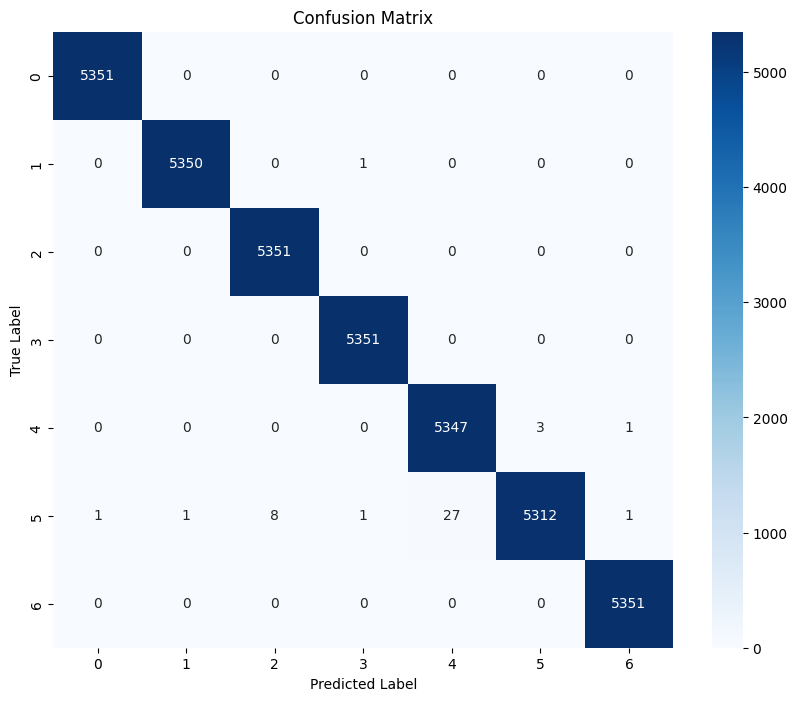

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from timeit import default_timer as timer
from tensorflow.keras.models import load_model



# Assuming the model_keras is already defined and trained
# Compile the model with the specified metric
# model_keras = load_model('initial_model83.h5')
# model_keras.compile(metrics=['accuracy'])

# Get the number of images in the training dataset
num_images = len(x_train_smote)

# Measure the time taken for Keras inference
start = timer()
potentials_keras = model_keras.predict(x_train_smote, batch_size=100)
end = timer()
print(f'Keras inference on {num_images} images took {end-start:.2f} s.\n')

# Get the predicted labels from the model output
preds_keras = np.argmax(potentials_keras, axis=1)

# Convert one-hot encoded y_train_smote back to class indices
y_train_smote_labels = np.argmax(y_train_smote, axis=1)

# Calculate the accuracy
accuracy_keras = np.sum(np.equal(preds_keras, y_train_smote_labels)) / num_images
print(f"Keras accuracy: {accuracy_keras*num_images:.0f}/{num_images}.")

# Generate the confusion matrix
cm = confusion_matrix(y_train_smote_labels, preds_keras)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_train_smote_labels), 
            yticklabels=np.unique(y_train_smote_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [56]:
model_keras.summary()

Model: "akidanet_derma"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                    

In [60]:
model_keras.save('initial_model83.h5')

In [58]:
# from tensorflow.keras.models import load_model

# model_keras = load_model('initial_model83.h5')

In [61]:

import tensorflow as tf

# Assuming x_train is your image data and y_train is your labels
x_train = x_train_smote # your x_train numpy array
y_train = y_train_smote # your y_train numpy array
IMG_SIZE = 64  # Set your image size here

# Function to format examples
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# Create a Dataset from x_train and y_train
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# Apply the format_example function
train_dataset = train_dataset.map(format_example, num_parallel_calls=tf.data.AUTOTUNE)


In [65]:
model_quantized = cnn2snn.quantize(model_keras,
                                   weight_quantization=4,
                                   activ_quantization=4,
                                   input_weight_quantization=8)

model_quantized = cnn2snn.quantize_layer(model_quantized, 'spike_generator/relu', 1)

model_quantized.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (QuantizedConv2D)    (None, 64, 64, 32)        896       
                                                                 
 re_lu (QuantizedReLU)       (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (QuantizedConv2D)  (None, 64, 64, 32)        9248      
                                                                 
 re_lu_1 (QuantizedReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                      

In [61]:

# # Define batch size and batch the dataset
# BATCH_SIZE = 100
# train_batches = train_dataset.batch(BATCH_SIZE)

# # Quantization parameters and quantization process
# from quantizeml.models import quantize, QuantizationParams, dump_config

# # Prepare a quantization scheme: first layer weights to 8-bit, other weights and activation to 4-bit
# qparams = QuantizationParams(input_weight_bits=8, per_tensor_activations=True, weight_bits=4, activation_bits=4)

# # Quantize the model, using the 1024 calibration samples from the train set and calibrate over 2
# # epochs with a batch_size of 100.
# model_quantized = quantize(model_keras, qparams=qparams,
#                            samples=train_batches, epochs=2, batch_size=BATCH_SIZE, num_samples=1024)

# model_quantized.summary()

2024-10-09 05:54:56.176558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [37303,7]
	 [[{{node Placeholder/_1}}]]


11/11 [==============================] - 0s 3ms/step
Model: "akidanet_derma"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8_input (InputLayer)  [(None, 64, 64, 3)]      0         
                                                                 
 conv2d_8 (QuantizedConv2D)  (None, 64, 64, 32)        896       
                                                                 
 re_lu_11 (QuantizedReLU)    (None, 64, 64, 32)        2         
                                                                 
 conv2d_9 (QuantizedConv2D)  (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_4 (QuantizedM  (None, 32, 32, 32)       0         
 axPool2D)                                                       
                                                                 
 re_lu_12 (QuantizedReLU)    (None, 32, 32, 32)        2         

375/375 [==============================] - 3s 7ms/step
Keras inference on 37457 images took 3.36 s.

Keras accuracy: 34085/37457.


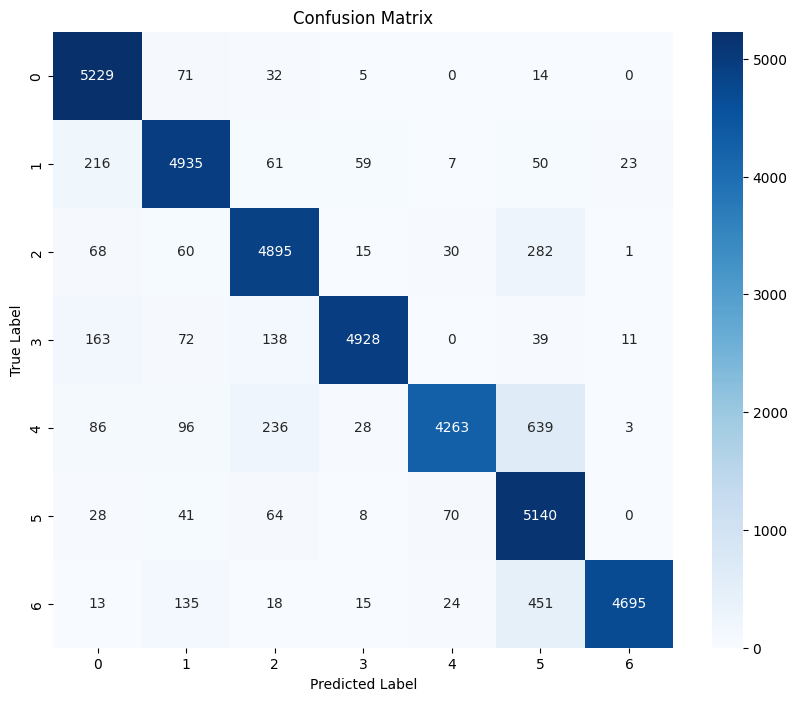

In [66]:
# Get the number of images in the training dataset
num_images = len(x_train_smote)

# Measure the time taken for Keras inference
start = timer()
potentials_keras = model_quantized.predict(x_train_smote, batch_size=100)
end = timer()
print(f'Keras inference on {num_images} images took {end-start:.2f} s.\n')

# Get the predicted labels from the model output
preds_keras = np.argmax(potentials_keras, axis=1)

# Convert one-hot encoded y_train_smote back to class indices
y_train_smote_labels = np.argmax(y_train_smote, axis=1)

# Calculate the accuracy
accuracy_keras = np.sum(np.equal(preds_keras, y_train_smote_labels)) / num_images
print(f"Keras accuracy: {accuracy_keras*num_images:.0f}/{num_images}.")

# Generate the confusion matrix
cm = confusion_matrix(y_train_smote_labels, preds_keras)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_train_smote_labels), 
            yticklabels=np.unique(y_train_smote_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [67]:
def compile_evaluate(model):
    """ Compiles and evaluates the model, then return accuracy score. """
    model.compile(metrics=['accuracy'])
    return model.evaluate(x_test, y_test, verbose=0)[1]


print('Test accuracy after 8-bit quantization:', compile_evaluate(model_quantized))

Test accuracy after 8-bit quantization: 0.785149097442627


In [68]:
from timeit import default_timer as timer
import numpy as np

num_images = len(x_test)

# Start timer
start = timer()

# Perform inference
potentials_keras = model_quantized.predict(x_test, batch_size=100)

# End timer
end = timer()
print(f'Keras inference on {num_images} images took {end-start:.2f} s.\n')

# Get the predicted class indices
preds_keras = np.squeeze(np.argmax(potentials_keras, 1))

# Convert y_test from one-hot encoded format to categorical format
y_test_categorical = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy_keras = np.sum(np.equal(preds_keras, y_test_categorical)) / num_images
print(f"Keras accuracy: {accuracy_keras*num_images:.0f}/{num_images}. {accuracy_keras*num_images/num_images}%")


33/33 [==============================] - 1s 12ms/step
Keras inference on 3286 images took 0.93 s.

Keras accuracy: 2568/3286. 0.7814972611077298%


In [65]:
y_test_categorical

array([0, 1, 3, ..., 5, 4, 1])

In [69]:
model_quantized.save('model_quantized.h5')

In [70]:
import numpy as np
from cnn2snn import convert

model_akida = convert(model_quantized)

In [71]:
model_akida.summary()

                Model Summary                 
______________________________________________
Input shape  Output shape  Sequences  Layers
[64, 64, 3]  [1, 1, 7]     1          13    
______________________________________________

___________________________________________________________________
Layer (type)                    Output shape   Kernel shape      

================= SW/conv2d-predictions (Software) ================

conv2d (InputConv.)             [64, 64, 32]   (3, 3, 3, 32)     
___________________________________________________________________
conv2d_1 (Conv.)                [32, 32, 32]   (3, 3, 32, 32)    
___________________________________________________________________
conv2d_2 (Conv.)                [32, 32, 64]   (3, 3, 32, 64)    
___________________________________________________________________
conv2d_3 (Conv.)                [16, 16, 64]   (3, 3, 64, 64)    
___________________________________________________________________
conv2d_4 (Conv.)            

In [72]:
model_akida.save('model_akida.fbz')

In [70]:
# from tensorflow.keras.models import load_model
# from akida_models import load_model


# model_path = 'model_akida.fbz'
# model = load_model(model_path)

# model.summary()

                Model Summary                 
______________________________________________
Input shape  Output shape  Sequences  Layers
[64, 64, 3]  [1, 1, 7]     1          13    
______________________________________________

___________________________________________________________________
Layer (type)                    Output shape   Kernel shape      

================ SW/conv2d_8-predictions (Software) ===============

conv2d_8 (InputConv.)           [64, 64, 32]   (3, 3, 3, 32)     
___________________________________________________________________
conv2d_9 (Conv.)                [32, 32, 32]   (3, 3, 32, 32)    
___________________________________________________________________
conv2d_10 (Conv.)               [32, 32, 64]   (3, 3, 32, 64)    
___________________________________________________________________
conv2d_11 (Conv.)               [16, 16, 64]   (3, 3, 64, 64)    
___________________________________________________________________
conv2d_12 (Conv.)           

/usr/local/lib/python3.8/dist-packages/onnx/__init__.py:108: RuntimeWarning: Unexpected end-group tag: Not all data was converted
  decoded = cast(Optional[int], proto.ParseFromString(s))


In [73]:
# Check Model performance
start = timer()
y_test_categorical = np.argmax(y_test, axis=1)
accuracy_akida = model_akida.evaluate(x_test, y_test_categorical)
end = timer()
print(f'Inference on {num_images} images took {end-start:.2f} s.\n')
print(f"Accuracy: {accuracy_akida*num_images:.0f}/{num_images}.")

Inference on 3286 images took 4.05 s.

Accuracy: 2573/3286.


: 

In [72]:
y_test_categorical = np.argmax(y_test, axis=1)
y_test_categorical

array([0, 1, 3, ..., 5, 4, 1])

In [73]:
import numpy as np

# # Count the occurrences of each class in y_test
# class_counts = np.bincount(y_test)
# print(class_counts)


In [74]:
import numpy as np

# Convert y_test from one-hot encoded to categorical format
y_test_categorical = np.argmax(y_test, axis=1)

# Count the occurrences of each class in the categorical y_test
class_counts = np.bincount(y_test_categorical)
print(class_counts)


[ 261  316  501  160  507 1376  165]


2024-10-10 04:30:41.527226: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 04:30:41.714233: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-10 04:30:43.385480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-10 04:30:43.40

NameError: name 'np' is not defined

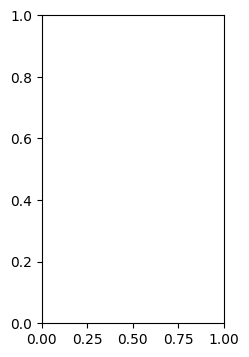

In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from akida_models.imagenet import preprocessing

class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

IMAGE_SIZE = 224
NUM_CHANNELS = 3

# Functions used to display the top5 results
def get_top5(potentials, true_label):
    """
    Returns the top 5 classes from the output potentials
    """
    tmp_pots = potentials.copy()
    top5 = []
    min_val = np.min(tmp_pots)
    for ii in range(5):
        best = np.argmax(tmp_pots)
        top5.append(best)
        tmp_pots[best] = min_val

    vals = np.zeros((6,))
    vals[:5] = potentials[top5]

    if true_label not in top5:
        vals[5] = potentials[true_label]
    else:
        vals[5] = 0

    vals /= np.max(vals)

    class_name = []
    for ii in range(5):
        class_name.append(class_names[top5[ii]])
    if true_label in top5:
        class_name.append('')
    else:
        class_name.append(
            class_names[true_label])

    return top5, vals, class_name


def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine
    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])


def prepare_plots():
    fig = plt.figure(figsize=(8, 4))
    # Image subplot
    ax0 = plt.subplot(1, 3, 1)
    imgobj = ax0.imshow(np.zeros((IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS), dtype=np.uint8))
    ax0.set_axis_off()
    # Top 5 results subplot
    ax1 = plt.subplot(1, 2, 2)
    bar_positions = (0, 1, 2, 3, 4, 6)
    rects = ax1.barh(bar_positions, np.zeros((6,)), align='center', height=0.5)
    plt.xlim(-0.2, 1.01)
    ax1.set(xlim=(-0.2, 1.15), ylim=(-1.5, 12))
    ax1.set_yticks(bar_positions)
    ax1.invert_yaxis()
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks([])
    adjust_spines(ax1, 'left')
    ax1.add_line(lines.Line2D((0, 0), (-0.5, 6.5), color=(0.0, 0.0, 0.0)))
    # Adjust Plot Positions
    ax0.set_position([0.05, 0.055, 0.3, 0.9])
    l1, b1, w1, h1 = ax1.get_position().bounds
    ax1.set_position([l1 * 1.05, b1 + 0.09 * h1, w1, 0.8 * h1])
    # Add title box
    plt.figtext(0.5,
                0.9,
                "Imagenet Classification by Akida",
                size=20,
                ha="center",
                va="center",
                bbox=dict(boxstyle="round",
                          ec=(0.5, 0.5, 0.5),
                          fc=(0.9, 0.9, 1.0)))

    return fig, imgobj, ax1, rects


def update_bars_chart(rects, vals, true_label):
    counter = 0
    for rect, h in zip(rects, yvals):
        rect.set_width(h)
        if counter < 5:
            if top5[counter] == true_label:
                if counter == 0:
                    rect.set_facecolor((0.0, 1.0, 0.0))
                else:
                    rect.set_facecolor((0.0, 0.5, 0.0))
            else:
                rect.set_facecolor('gray')
        elif counter == 5:
            rect.set_facecolor('red')
        counter += 1


# Prepare plots
fig, imgobj, ax1, rects = prepare_plots()

# Get a random image
img = np.random.randint(num_images)

# Predict image class
outputs_akida = model_akida.predict(np.expand_dims(x_test[img].astype(np.uint8), axis=0)).squeeze()

# Get top 5 prediction labels and associated names
true_label = y_test_categorical[img]
top5, yvals, class_name = get_top5(outputs_akida, true_label)

print("Akida outputs:", outputs_akida)
print("True label:", class_names[int(true_label)])
print("Predicted label:", class_names[np.argmax(outputs_akida)])

# Draw Plots
imgobj.set_data(x_test[img])
ax1.set_yticklabels(class_name, rotation='horizontal', size=9)
update_bars_chart(rects, yvals, true_label)
fig.canvas.draw()
plt.show()

------

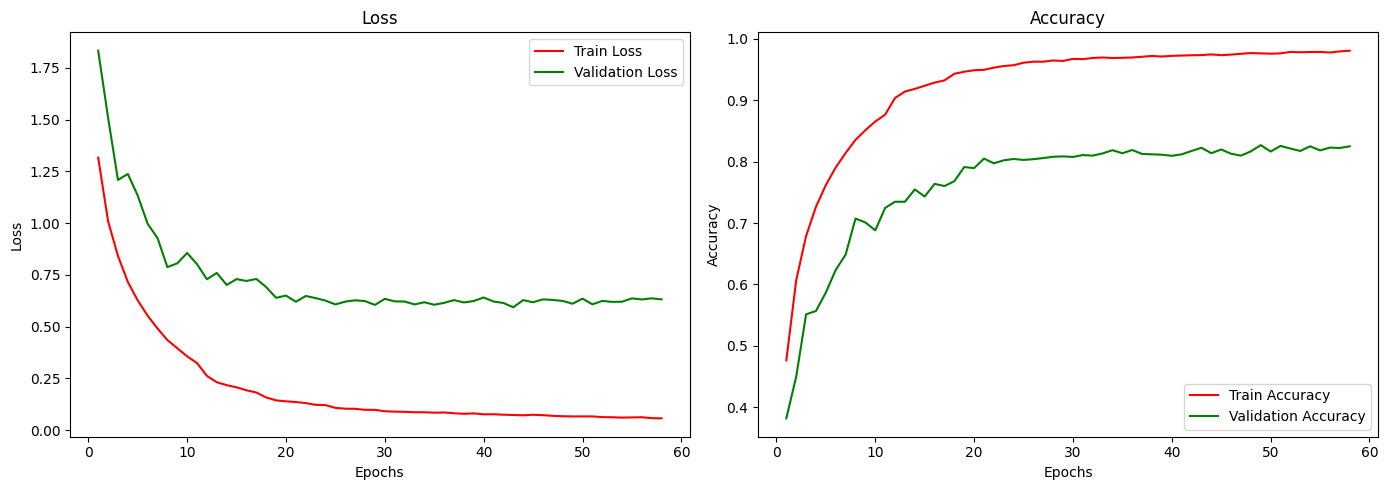

In [76]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

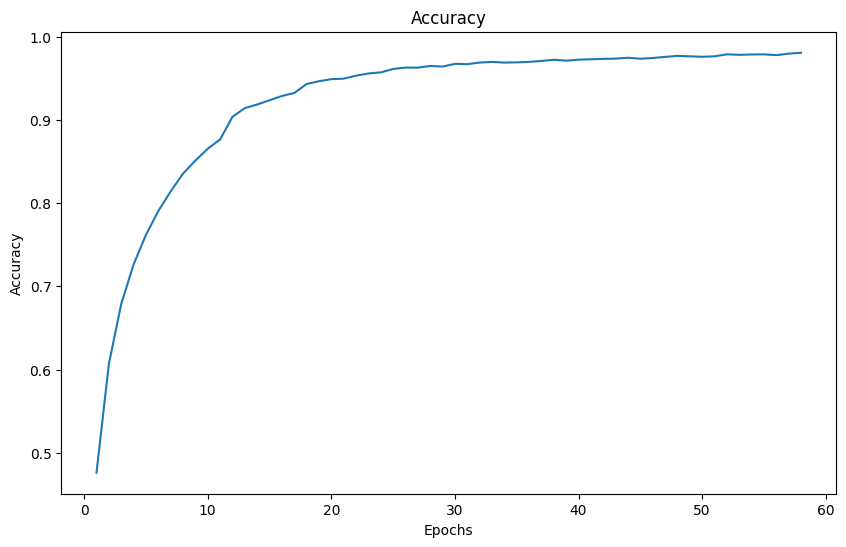

In [77]:
tr_acc = history.history['accuracy']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, tr_acc)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

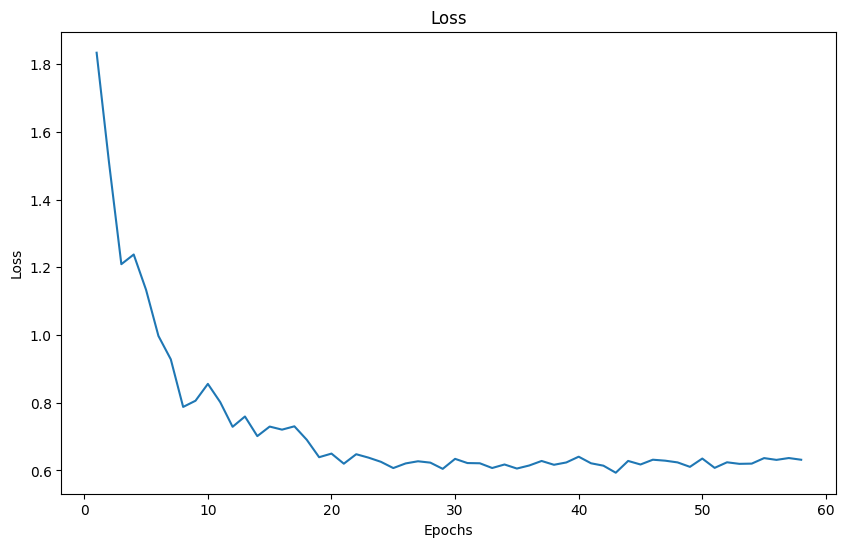

In [78]:
tr_acc = history.history['val_loss']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, tr_acc)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [ ]:
#model.save("/kaggle/working/model.h5")

In [ ]:
predictions = model.predict(x_test)

In [ ]:
cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
cm

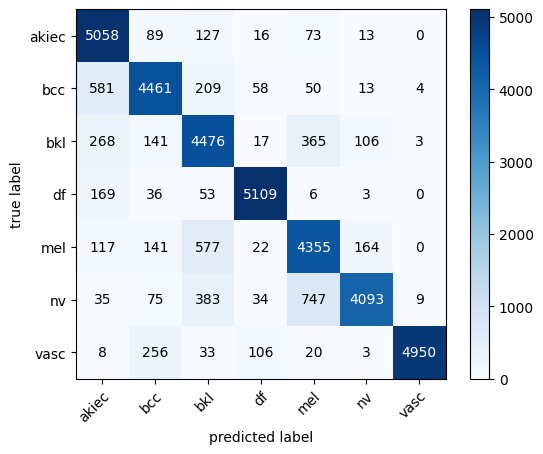

In [ ]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=cm_plot_labels, colorbar=True)
plt.show()

In [ ]:
report = classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=cm_plot_labels, output_dict=True)

df_classification_report = pd.DataFrame(report).transpose()
df_classification_report.drop(["accuracy", "macro avg", "weighted avg"], inplace=True)
df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
df_classification_report["precision"] = df_classification_report["precision"].map(lambda x: round(x, 3))
df_classification_report["recall"] = df_classification_report["recall"].map(lambda x: round(x, 3))
df_classification_report["f1-score"] = df_classification_report["f1-score"].map(lambda x: round(x, 3))
df_classification_report["support"] = df_classification_report["support"].map(int)
df_classification_report

The number of weights corresponds to the number of connections for each neuron. The smaller the number of weights, the less specific the neurons will be. Setting this parameter correctly is important.

Although the last trainable layer hasn’t been created yet, we can already estimate the number of weights. This estimation is based on the statistics of the output spikes from the feature extractor. Intuitively, a sample producing N spikes at the end of the feature extractor could be perfectly represented with a neuron with N weights. We then use the median of the number of output spikes for all samples.

To reduce computing time, using only a subset of the whole dataset may be sufficient to get an estimation of the number of spikes. We then set the number of weights to a value sligthly higher than the median of the number of spikes: we generally choose 1.2 x median of number of spikes, which seems to give good results.

In [ ]:
# Forward samples to get the number of output spikes
# Here, 10% of the training set is sufficient for a good estimation
model_akida.pop_layer()
num_samples_to_use = int(len(x_train) / 10)
spikes = model_akida.forward(x_train[:num_samples_to_use].astype(np.uint8))

# Compute the median of the number of output spikes
median_spikes = np.median(spikes.sum(axis=(1, 2, 3)))
print(f"Median of number of spikes: {median_spikes}")

# Set the number of weights to 1.2 x median
num_weights = int(1.2 * median_spikes)
print(f"The number of weights is then set to: {num_weights}")

Median of number of spikes: 429.0
The number of weights is then set to: 514
